In [1]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Line 3: Mount Google Drive (to upload your dataset or save models)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q "/content/drive/My Drive/Dataset_465_short.zip" -d /content/
dataset_path = "/content/Dataset"

replace /content/Dataset/Female/100_1_0_20170110183726390.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,  # Your dataset path
    shuffle=True,
    image_size=(128, 128),  # Resize the images to 200 x 200
    batch_size= 16
)

Found 19474 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Female', 'Male']


In [5]:
len_dataset = len(dataset)
print(f"Total samples: {len_dataset}")

for img, label in dataset.take(1):
    print(img.shape)
    print(label.numpy())

Total samples: 1218
(16, 128, 128, 3)
[1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1]


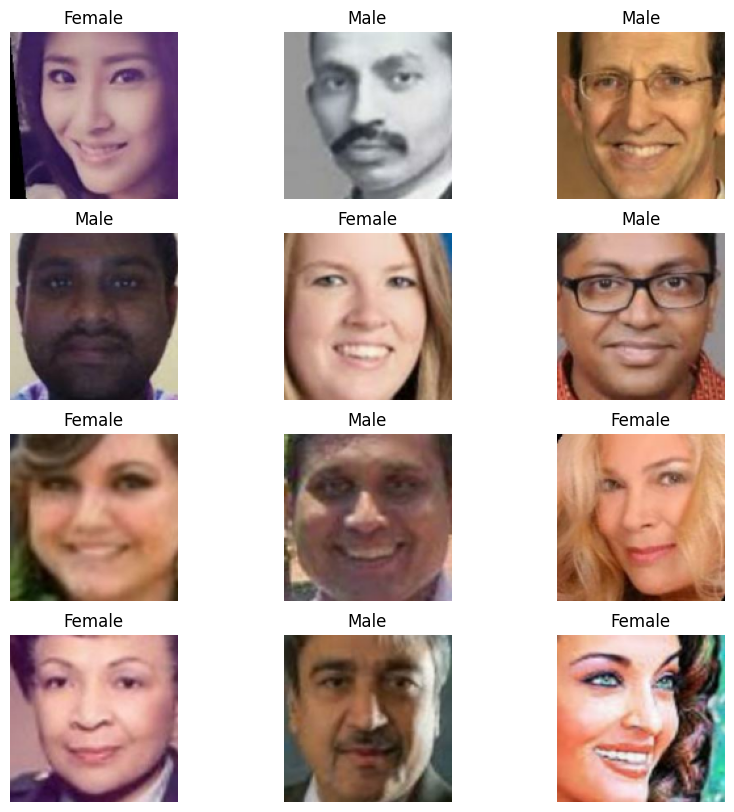

In [6]:
plt.figure(figsize=(10, 10))
for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

Exploratory Data Anlysis


In [7]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [8]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(128, 128),
    tf.keras.layers.Rescaling(1.0/255)
])

Feature Extraction

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [11]:
model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Input shape remains the same
    resize_and_rescale,
    data_augmentation,

    # Reshape the data for LSTM
    layers.Reshape((128, 384)),  # Flatten spatial dimensions into sequences

    # LSTM layers
    layers.LSTM(128, return_sequences=True),  # First LSTM layer with output sequences
    layers.LSTM(64),


    # Fully connected layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax'),
])

In [12]:
from keras import mixed_precision

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 384)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128, 128)            │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329,218 (1.26 MB)

 Trainable params: 329,218 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=16
)

Epoch 1/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.5462 - loss: 0.6944 - val_accuracy: 0.6746 - val_loss: 0.6396
Epoch 2/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6028 - loss: 0.6666 - val_accuracy: 0.6555 - val_loss: 0.6330
Epoch 3/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6404 - loss: 0.6413 - val_accuracy: 0.6327 - val_loss: 0.6326
Epoch 4/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6742 - loss: 0.6137 - val_accuracy: 0.7009 - val_loss: 0.5903
Epoch 5/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6864 - loss: 0.6002 - val_accuracy: 0.7045 - val_loss: 0.5675
Epoch 6/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6958 - loss: 0.5896 - val_accuracy: 0.6968 - val_loss: 0.5867
Epoch 7/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.6969 - loss: 0.5921 - val_accuracy: 0.7030 - val_loss: 0.5707
Epoch 8/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7023 - loss: 0.5852 - 

In [15]:
test_scores = model.evaluate(test_dataset)
test_scores

123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7904 - loss: 0.4340


[0.45105525851249695, 0.7840447425842285]

In [16]:
train_scores = model.evaluate(train_dataset)
train_scores

974/974 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8007 - loss: 0.4411


[0.44155678153038025, 0.7981262803077698]

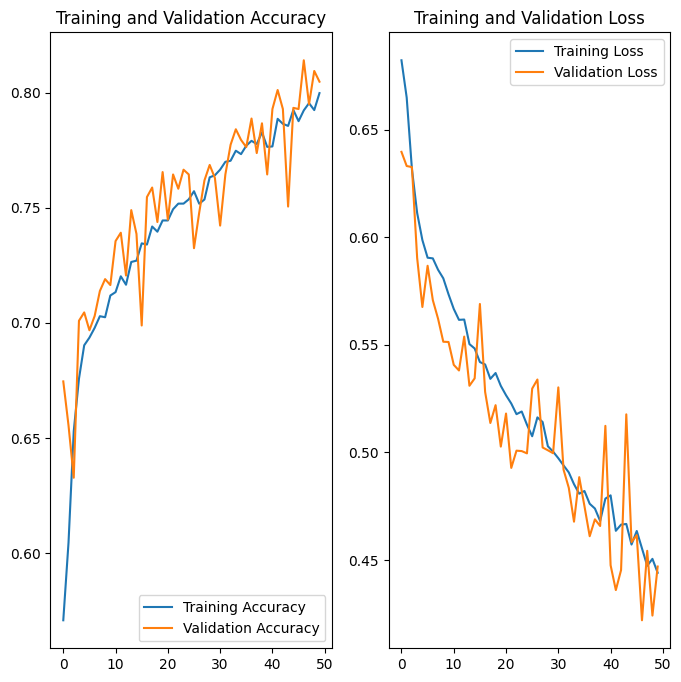

In [17]:
history_data = history.history
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']
loss = history_data['loss']
val_loss = history_data['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Actual Label: Female
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted Label: Female


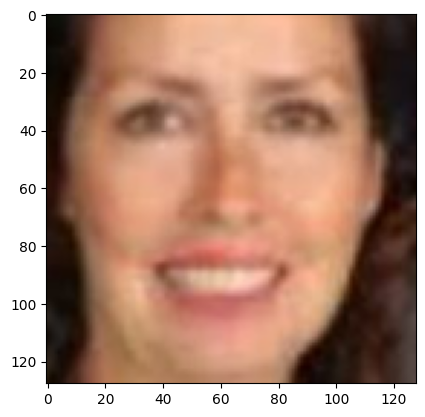

In [18]:
for img, label in test_dataset.take(1):
    first_image = img[0].numpy().astype("uint8")
    first_label = label[0].numpy()

    plt.imshow(first_image, cmap='gray')
    print(f"Actual Label: {class_names[first_label]}")

    batch_prediction = model.predict(img)
    predicted_class = np.argmax(batch_prediction[0])
    print(f"Predicted Label: {class_names[predicted_class]}")

In [19]:
model_version = 'CNN_Model1(Gender)'
model.save(f"/content/drive/My Drive/{model_version}.keras")
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

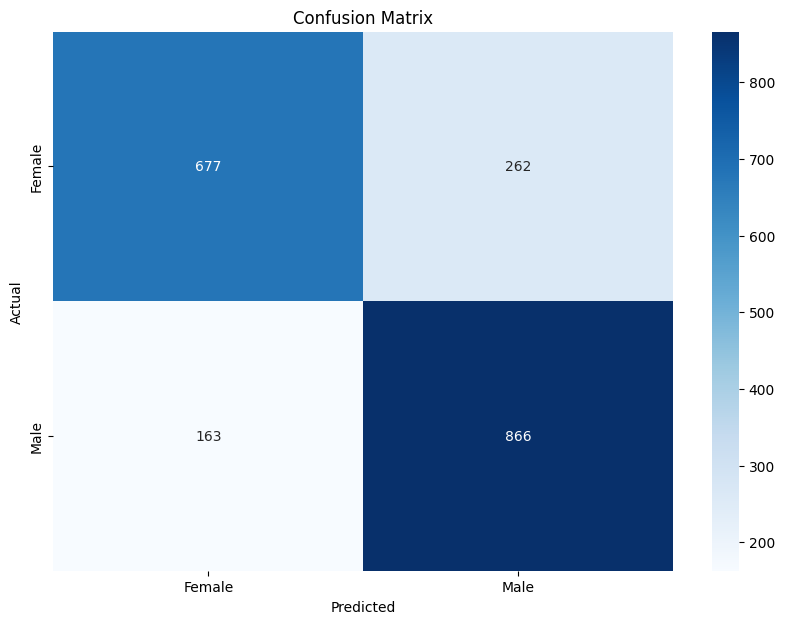

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for img, label in test_dataset:
    preds = model.predict(img)
    y_true.extend(label.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [21]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.7859674626856451
Recall: 0.7840447154471545
F1 Score: 0.7829917000013406
